# Load Libraries

In [1]:
# Install RPostgres if needed:
#install.packages("RPostgres")
#install.packages("tidyverse")

In [2]:
library(DBI)
library(ggplot2)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
✔ purrr   1.0.0      
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [3]:
mytheme <- function() {
  return(theme_bw() +
           theme(
             # NOTE: UNCOMMENT WHEN RENDING PLOTS FOR THE PAPER
             # (can't get the CM fonts to work in artifact VM...)
             text = element_text(family = "Times", size=10),
              panel.grid.major = element_blank(),
             # panel.grid.minor = element_blank(),
             # panel.grid.major = element_line(colour="gray", size=0.1),
             # panel.grid.minor =
             #  element_line(colour="gray", size=0.1, linetype='dotted'),
             axis.ticks = element_line(size=0.05),
             axis.ticks.length=unit("-0.05", "in"),
             axis.text.y = element_text(margin = margin(r = 5)),
             axis.text.x = element_text(hjust=1),
             legend.key = element_rect(colour=NA),
             legend.spacing = unit(0.001, "in"),
             legend.key.size = unit(0.2, "in"),
             legend.title = element_blank(),
             legend.position = c(0.75, .7),
             legend.background = element_blank()))
}

mythemeboxplot <- function() {
  return(theme_bw() +
           theme(
             # NOTE: UNCOMMENT WHEN RENDING PLOTS FOR THE PAPER
             # (can't get the CM fonts to work in artifact VM...)
             text = element_text(family = "Times", size=10),
              panel.grid.major = element_blank(),
             # panel.grid.minor = element_blank(),
             # panel.grid.major = element_line(colour="gray", size=0.1),
             # panel.grid.minor =
             #  element_line(colour="gray", size=0.1, linetype='dotted'),
             axis.ticks = element_line(size=0.05),
             axis.ticks.length=unit("-0.05", "in"),
             axis.text.y = element_text(margin = margin(r = 5)),
            #  axis.text.x = element_text(hjust=1),
             legend.key = element_rect(colour=NA),
             legend.spacing = unit(0.001, "in"),
             legend.key.size = unit(0.2, "in"),
            #  legend.title = element_blank(),
            #  legend.position = c(0.75, .7),
             legend.background = element_blank()))
}

mysave <- function(filename) {
  ggsave(filename, width=6, height=4.5, units=c("in"))
  # embed_font(path)
}

# Connect to DB, load data, clean data

In [4]:
con <- dbConnect(
    RPostgres::Postgres(),
    dbname = 'npm_data', 
    user = 'data_analyzer',
)

In [5]:
# This takes about 40 seconds to load (when running on the VM!), and takes about 4GB of memory
all_updates <- dbGetQuery(con, "
    SELECT 
        package_id, 
        from_id, 
        to_id, 
        (from_semver).major AS from_semver_major, 
        (from_semver).minor AS from_semver_minor, 
        (from_semver).bug AS from_semver_bug,
        (to_semver).major AS to_semver_major, 
        (to_semver).minor AS to_semver_minor, 
        (to_semver).bug AS to_semver_bug,
        from_created,
        to_created,
        ty,
        ROW(from_id, to_id) IN (SELECT from_id, to_id FROM metadata_analysis.vuln_intro_updates) as did_intro_vuln,
        ROW(from_id, to_id) IN (SELECT from_id, to_id FROM metadata_analysis.vuln_patch_updates) as did_patch_vuln
    FROM metadata_analysis.all_updates
")

In [6]:
all_updates_sub <- all_updates[sample(nrow(all_updates), 100000),] 

In [7]:
all_updates <- all_updates %>% filter(ty != "zero_to_something")

In [8]:
all_updates$ty <- sapply(all_updates$ty, as.character)
all_updates$tyFact <- factor(all_updates$ty, levels=c("bug", "minor", "major"))

In [9]:
head(all_updates)

,package_id,from_id,to_id,from_semver_major,from_semver_minor,from_semver_bug,to_semver_major,to_semver_minor,to_semver_bug,from_created,to_created,ty,did_intro_vuln,did_patch_vuln,tyFact
,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<dttm>,<dttm>,<chr>,<lgl>,<lgl>,<fct>
1,335,1,2,1,0,2,1,2,0,2016-12-10 03:59:44,2016-12-10 06:28:00,minor,FALSE,FALSE,minor
2,335,2,3,1,2,0,1,2,1,2016-12-10 06:28:00,2016-12-10 16:48:25,bug,FALSE,FALSE,bug
3,335,3,4,1,2,1,1,2,2,2016-12-10 16:48:25,2016-12-10 16:50:43,bug,FALSE,FALSE,bug
4,335,4,5,1,2,2,1,2,3,2016-12-10 16:50:43,2016-12-10 17:03:01,bug,FALSE,FALSE,bug
5,335,5,6,1,2,3,1,3,0,2016-12-10 17:03:01,2016-12-10 19:07:46,minor,FALSE,FALSE,minor
6,335,6,7,1,3,0,1,4,0,2016-12-10 19:07:46,2016-12-10 19:59:41,minor,FALSE,FALSE,minor


In [10]:
patches_only <- all_updates %>% filter(did_patch_vuln == TRUE & did_intro_vuln == FALSE)
others <- all_updates %>% filter(did_patch_vuln == FALSE | did_intro_vuln == TRUE)

# select the row with ty ordered bug,minor,major for each from_id
patches_lowest_type <- patches_only %>% group_by(from_id) %>% top_n(-1, tyFact)
patches_first_created <- patches_only %>% group_by(from_id) %>% top_n(-1, to_created)

In [11]:
patches_only

package_id,from_id,to_id,from_semver_major,from_semver_minor,from_semver_bug,to_semver_major,to_semver_minor,to_semver_bug,from_created,to_created,ty,did_intro_vuln,did_patch_vuln,tyFact
<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<dttm>,<dttm>,<chr>,<lgl>,<lgl>,<fct>
128542,124145,124146,1,6,2,1,6,3,2015-02-17 03:56:46,2015-03-14 05:24:28,bug,FALSE,TRUE,bug
171591,356186,356187,0,5,0,0,5,1,2015-07-14 17:21:09,2015-11-17 16:49:56,bug,FALSE,TRUE,bug
179130,395178,395179,1,6,0,1,7,0,2013-07-04 03:03:00,2015-01-09 03:38:00,minor,FALSE,TRUE,minor
186599,427653,427654,2,0,0,2,0,1,2015-10-03 06:02:34,2015-12-06 10:51:29,bug,FALSE,TRUE,bug
204297,431056,431057,1,0,0,1,0,1,2017-09-11 15:37:10,2017-09-11 15:41:04,bug,FALSE,TRUE,bug
204549,431114,431115,0,9,0,0,9,1,2017-10-14 04:55:27,2017-10-14 14:14:28,bug,FALSE,TRUE,bug
518556,531487,531488,3,2,9,3,2,10,2019-12-09 19:17:44,2020-11-05 00:33:05,bug,FALSE,TRUE,bug
521460,569672,569673,0,1,9,0,1,10,2021-12-16 21:17:29,2022-03-02 22:40:24,bug,FALSE,TRUE,bug
551229,854318,854319,1,7,0,1,9,0,2020-09-24 21:56:05,2021-05-27 18:26:23,minor,FALSE,TRUE,minor


# Make plots!

### What proportion of each package's update are each type?

In [12]:
# creates a data frame with one row per package, and columns for count of each update type
updateCountsByPackage <- all_updates %>%
    group_by(package_id,did_intro_vuln,did_patch_vuln,tyFact) %>%
    summarise(
        count = n()
    ) %>% 
    pivot_wider(names_from = tyFact, values_from = count, values_fill=0) %>%
    mutate(total = bug + minor + major,
           bugPct = bug / total,
           majorPct = major / total,
           minorPct = minor / total,
    ) %>%
    mutate(update_action = ifelse(did_intro_vuln, 'Intro vuln', ifelse(did_patch_vuln, 'Patch vuln', 'No security effect')))

`summarise()` has grouped output by 'package_id', 'did_intro_vuln',
'did_patch_vuln'. You can override using the `.groups` argument.


In [13]:
head(updateCountsByPackage)

package_id,did_intro_vuln,did_patch_vuln,bug,minor,major,total,bugPct,majorPct,minorPct,update_action
<int64>,<lgl>,<lgl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
335,FALSE,FALSE,150,182,12,344,0.4360465,0.03488372,0.5290698,No security effect
336,FALSE,FALSE,2,0,0,2,1.0000000,0.00000000,0.0000000,No security effect
337,FALSE,FALSE,1,0,0,1,1.0000000,0.00000000,0.0000000,No security effect
341,FALSE,FALSE,384,233,18,635,0.6047244,0.02834646,0.3669291,No security effect
488,FALSE,FALSE,1,0,1,2,0.5000000,0.50000000,0.0000000,No security effect
2580,FALSE,FALSE,2,1,0,3,0.6666667,0.00000000,0.3333333,No security effect


In [14]:
# make a long version of it for ggplot
updateCountsByPackageLong <- updateCountsByPackage %>%
    pivot_longer(cols=ends_with("Pct"), names_to="ty", values_to="pct")

In [15]:
updateCountsByPackageLong$update_action <- factor(updateCountsByPackageLong$update_action, levels=c('No security effect', 'Intro vuln', 'Patch vuln'))
updateCountsByPackageLong$ty <- recode(updateCountsByPackageLong$ty, bugPct='Bug', minorPct='Minor', majorPct='Major')
updateCountsByPackageLong$ty <- factor(updateCountsByPackageLong$ty, levels=c('Bug', 'Minor', 'Major'))

In [16]:
head(updateCountsByPackageLong)

package_id,did_intro_vuln,did_patch_vuln,bug,minor,major,total,update_action,ty,pct
<int64>,<lgl>,<lgl>,<int>,<int>,<int>,<int>,<fct>,<fct>,<dbl>
335,FALSE,FALSE,150,182,12,344,No security effect,Bug,0.43604651
335,FALSE,FALSE,150,182,12,344,No security effect,Major,0.03488372
335,FALSE,FALSE,150,182,12,344,No security effect,Minor,0.52906977
336,FALSE,FALSE,2,0,0,2,No security effect,Bug,1.00000000
336,FALSE,FALSE,2,0,0,2,No security effect,Major,0.00000000
336,FALSE,FALSE,2,0,0,2,No security effect,Minor,0.00000000


Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


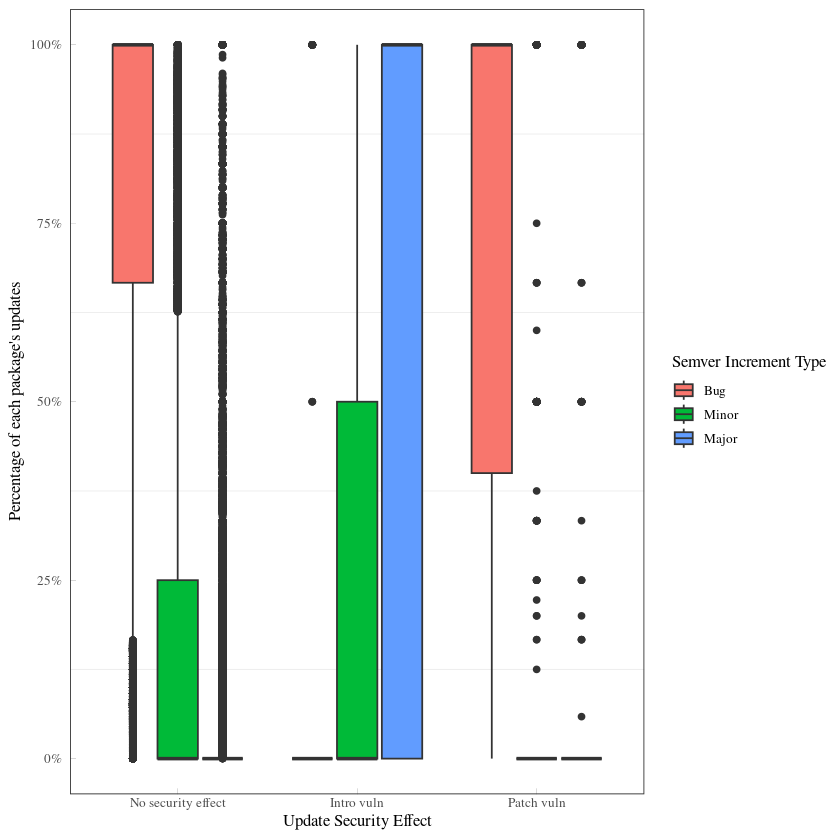

In [17]:
# box plots of the percentage of updates that are each type
ggplot(data = updateCountsByPackageLong, aes(x = update_action, y = pct, fill=ty)) +
    geom_boxplot() +
    #sets the labels for the x-axis:
    # scale_x_discrete(limits=c("normal", "introduce vuln", "patch vuln")) +
    scale_y_continuous(labels = scales::percent) + 
    #sets the title of the plot
    labs(fill='Semver Increment Type', x='Update Security Effect', y = 'Percentage of each package\'s updates') + 
    mythemeboxplot()

mysave("plots/rq2/update_type_with_security.png")

Warning message:
“The `fun.y` argument of `stat_summary()` is deprecated as of ggplot2 3.3.0.
ℹ Please use the `fun` argument instead.”
Warning message:
“The dot-dot notation (`..y..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(y)` instead.”


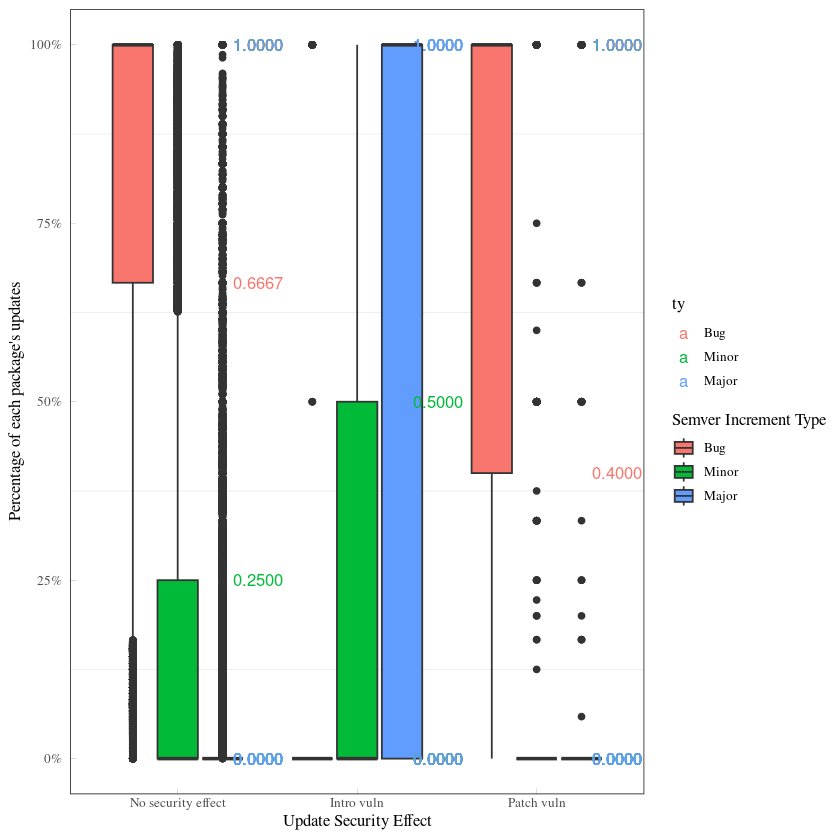

In [18]:


# box plots of the percentage of updates that are each type
ggplot(data = updateCountsByPackageLong, aes(x = update_action, y = pct, fill=ty)) +
    geom_boxplot() +
    stat_summary(geom="text", fun.y=quantile,
               aes(label=sprintf("%1.4f", ..y..), x=update_action, color=ty),
               position=position_nudge(x=0.45), 
               size=3.5) +

    #sets the labels for the x-axis:
    # scale_x_discrete(limits=c("normal", "introduce vuln", "patch vuln")) +
    scale_y_continuous(labels = scales::percent) + 
    #sets the title of the plot
    labs(fill='Semver Increment Type', x='Update Security Effect', y = 'Percentage of each package\'s updates') + 
    mythemeboxplot()

# mysave("plots/rq2/update_type_with_security.png")

## How frequent are each update type overall?

In [19]:
print(updateCountsByPackage %>% ungroup() %>% summarize(
    sum_total = sum(total),
    sum_bug = sum(bug),
    sum_minor = sum(minor),
    sum_major = sum(major),
    bugPct = 100 * sum_bug / sum_total,
    majorPct = 100 * sum_major / sum_total,
    minorPct = 100 * sum_minor / sum_total,
))

# A tibble: 1 × 7
  sum_total  sum_bug sum_minor sum_major bugPct majorPct minorPct
      <int>    <int>     <int>     <int>  <dbl>    <dbl>    <dbl>
1  16547653 13435294   2622485    489874   81.2     2.96     15.8


In [21]:
n_distinct(updateCountsByPackage$package_id)

[1] 1401510

# When are patches non-bug?

In [28]:
updateCountsByPackage %>% ungroup() %>% filter(did_patch_vuln)

package_id,did_intro_vuln,did_patch_vuln,bug,minor,major,total,bugPct,majorPct,minorPct,update_action
<int64>,<lgl>,<lgl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
126517,FALSE,TRUE,0,0,1,1,0,1,0,Patch vuln
128542,FALSE,TRUE,1,0,0,1,1,0,0,Patch vuln
131189,FALSE,TRUE,0,1,0,1,0,0,1,Patch vuln
155163,FALSE,TRUE,0,1,0,1,0,0,1,Patch vuln
155938,FALSE,TRUE,1,0,0,1,1,0,0,Patch vuln
171591,FALSE,TRUE,1,0,0,1,1,0,0,Patch vuln
179130,FALSE,TRUE,0,1,0,1,0,0,1,Patch vuln
186599,FALSE,TRUE,1,0,0,1,1,0,0,Patch vuln
204297,FALSE,TRUE,1,0,0,1,1,0,0,Patch vuln


# When are vuln introductions bug updates?

In [52]:
bug_intro_vuln <- updateCountsByPackage %>% ungroup() %>% filter(did_intro_vuln & bug > 0) 

In [53]:
num_packages_bug_intro_vuln <- n_distinct(bug_intro_vuln$package_id)
num_updates_bug_intro_vuln <- sum(bug_intro_vuln$bug)
print(paste("Number of packages with bug updates that introduce vulns:", num_packages_bug_intro_vuln))
print(paste("Number of bug updates that introduce vulns:", num_updates_bug_intro_vuln))

[1] "Number of packages with bug updates that introduce vulns: 29"
[1] "Number of bug updates that introduce vulns: 29"


# When are vuln patches non-bug updates?

In [54]:
non_bug_patch_vuln <- updateCountsByPackage %>% ungroup() %>% filter(did_patch_vuln & (minor > 0 | major > 0))
num_packages_non_bug_patch_vuln <- n_distinct(non_bug_patch_vuln$package_id)
num_updates_non_bug_patch_vuln <- sum(non_bug_patch_vuln$minor) + sum(non_bug_patch_vuln$major)
print(paste("Number of packages with non-bug updates that patch vulns:", num_packages_non_bug_patch_vuln))
print(paste("Number of non-bug updates that patch vulns:", num_updates_non_bug_patch_vuln))

[1] "Number of packages with non-bug updates that patch vulns: 298"
[1] "Number of non-bug updates that patch vulns: 358"
